# Project ADA - CMU Movie Summary Corpus

### YAMAL Team

### To do

- check how genre are classified (Is the first one the most important one?)

### Useful libraries

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

### Loading data set

In [3]:
DATA_FOLDER = './Data_set/'


# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB', 
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name', 
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'character.metadata.tsv', names=columns_char, 
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])


# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

movies = pd.read_table(DATA_FOLDER+'movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

In [4]:
# Splitting release date into year and month

movie_release_year = []
movie_release_month = []
for release_date in movies['Movie_release_date']:
    if '-' in str(release_date):
        splitted_date = release_date.split('-')
        movie_release_year.append(splitted_date[0])
        movie_release_month.append(splitted_date[1])
    else :
        movie_release_year.append(str(release_date)[:4])
        movie_release_month.append(None)
movies['Movie_release_year'] = movie_release_year
movies['Movie_release_month'] = movie_release_month
movies.drop('Movie_release_date', axis = 1, inplace = True)
movies.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,None


In [5]:
#It seems that a movie has a release date of 1010, this is clearly an outlier, let us remove it.

movies.groupby('Movie_release_year').size()

Movie_release_year
1010       1
1888       1
1889       1
1890       2
1891       3
        ... 
2013     164
2014      17
2015       4
2016       3
nan     6902
Length: 131, dtype: int64

In [6]:
movies.Movie_release_year = movies.Movie_release_year.replace('1010', '2010')

In [7]:
def split_action_advent(x):
    if 'Action/Adventure' in x:
        idx = x.index('Action/Adventure')
        x[idx: idx+1] = ('Action', 'Adventure')
    return x  

In [8]:
# Drop IDs before movie language, genre and country and split genre into a list

movies['Movie_genres'] = movies['Movie_genres'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

movies['Movie_genres'] = movies['Movie_genres'].apply(split_action_advent)
movies['Movie_genres'] = movies[movies['Movie_genres']!='Film \u00e0']['Movie_genres']

movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

movies['Movie_languages'] = movies['Movie_languages'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', '').replace(' Language', ''))[1::2])

In [9]:
movies.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None


In [10]:
# Keep only the 3 first countries

movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: x[:3])

# Create new column for the 3 countries

countries = [[], [], []]

for country in movies['Movie_countries']:
    for i in range(3):
        if i < len(country):
            countries[i].append(str(country[i]))
        else:
            countries[i].append(np.nan)

movies['Movie_country_1'] = countries[0]
movies['Movie_country_2'] = countries[1]
movies['Movie_country_3'] = countries[2]

movies.drop(columns='Movie_countries')

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_genres,Movie_release_year,Movie_release_month,Movie_country_1,Movie_country_2,Movie_country_3
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,United States of America,NaN,NaN
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,United States of America,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],"[Crime Fiction, Drama]",1988,None,Norway,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],"[Thriller, Erotic thriller, Psychological thri...",1987,None,United Kingdom,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Drama],1983,None,Germany,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,[English],[Drama],2011,03,United States of America,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,[English],"[Biographical film, Drama, Documentary]",2011,01,Ireland,United Kingdom,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,[English],"[Satire, Comedy]",1972,09,United States of America,NaN,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,[Japanese],"[Science Fiction, Japanese Movies, Adventure, ...",1992,05,Japan,NaN,NaN


In [11]:
# Keep only the 3 first genre

movies['Movie_genres'] = movies['Movie_genres'].apply(lambda x: x[:3])

# Create new column for the 3 genre

genres = [[], [], []]

for genre in movies['Movie_genres']:
    for i in range(3):
        if i < len(genre):
            genres[i].append(str(genre[i]))
        else:
            genres[i].append(np.nan)

movies['Movie_genre_1'] = genres[0]
movies['Movie_genre_2'] = genres[1]
movies['Movie_genre_3'] = genres[2]

movies.drop(columns='Movie_genres')

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_release_year,Movie_release_month,Movie_country_1,Movie_country_2,Movie_country_3,Movie_genre_1,Movie_genre_2,Movie_genre_3
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001,08,United States of America,NaN,NaN,Thriller,Science Fiction,Horror
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000,02,United States of America,NaN,NaN,Mystery,Biographical film,Drama
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],1988,None,Norway,NaN,NaN,Crime Fiction,Drama,NaN
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],1987,None,United Kingdom,NaN,NaN,Thriller,Erotic thriller,Psychological thriller
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],1983,None,Germany,NaN,NaN,Drama,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,[English],[United States of America],2011,03,United States of America,NaN,NaN,Drama,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,[English],"[Ireland, United Kingdom]",2011,01,Ireland,United Kingdom,NaN,Biographical film,Drama,Documentary
81738,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,[English],[United States of America],1972,09,United States of America,NaN,NaN,Satire,Comedy,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,[Japanese],[Japan],1992,05,Japan,NaN,NaN,Science Fiction,Japanese Movies,Adventure


In [12]:
# Replace missing values in list features by np.nan

movies['Movie_languages'] = movies['Movie_languages'].apply(lambda x: np.nan if x == [] else x)
movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: np.nan if x == [] else x)

### Visualize data set

#### 1) Movies

In [13]:
countries = movies[['Movie_country_1', 'Movie_country_2', 'Movie_country_3']].apply(pd.Series.value_counts).sum(axis=1)

In [14]:
top20_countries = countries.sort_values(ascending = False)[:20]

Text(0, 0.5, 'Number of movies')

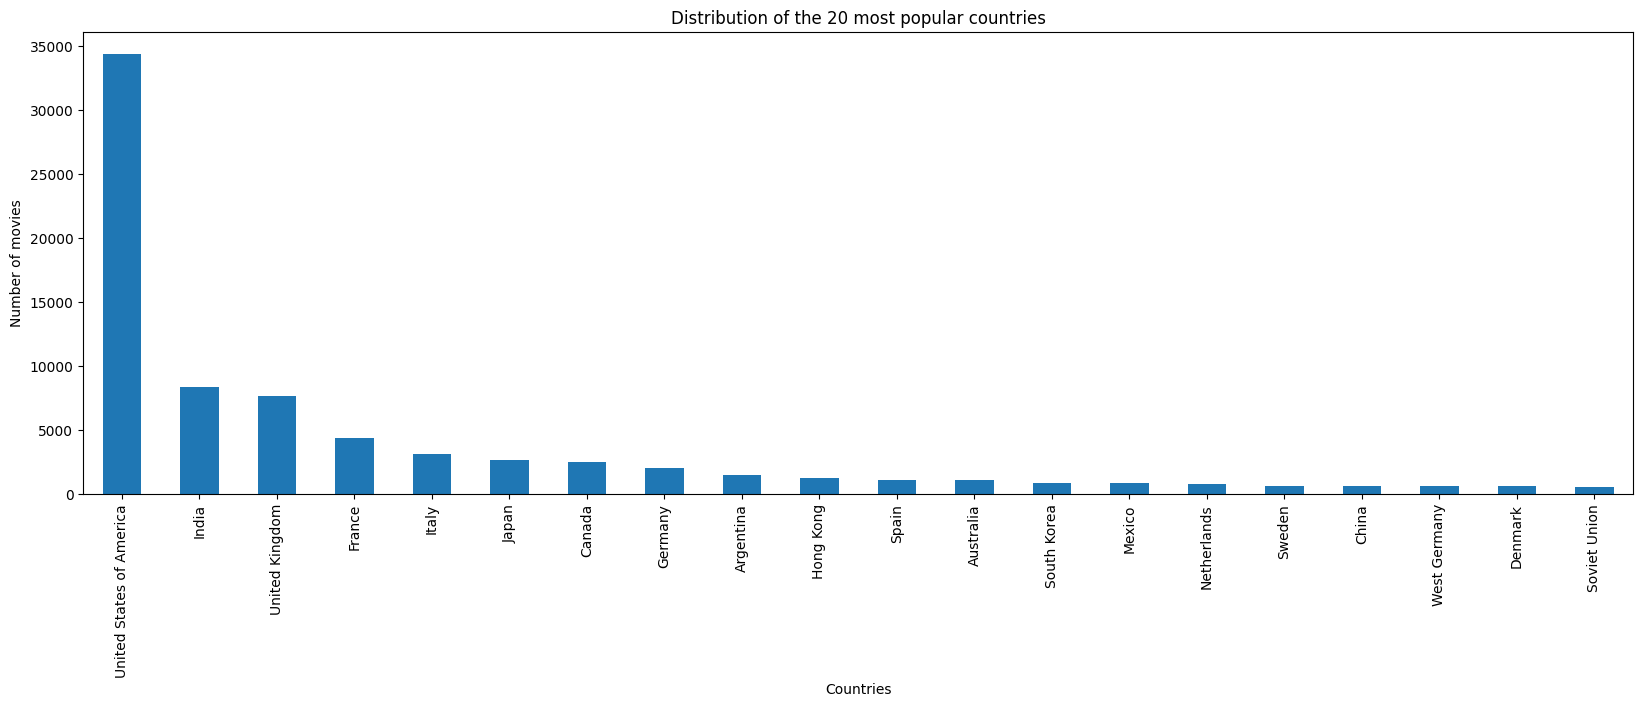

In [15]:
plt.figure(figsize=(20,6))
top20_countries.plot.bar()
plt.title("Distribution of the 20 most popular countries")
plt.xlabel('Countries')
plt.ylabel('Number of movies')

In [16]:
genres = movies[['Movie_genre_1', 'Movie_genre_2', 'Movie_genre_3']].apply(pd.Series.value_counts).sum(axis=1)

In [17]:
top20_genres = genres.sort_values(ascending = False)[:20]

Text(0, 0.5, 'Number of movies')

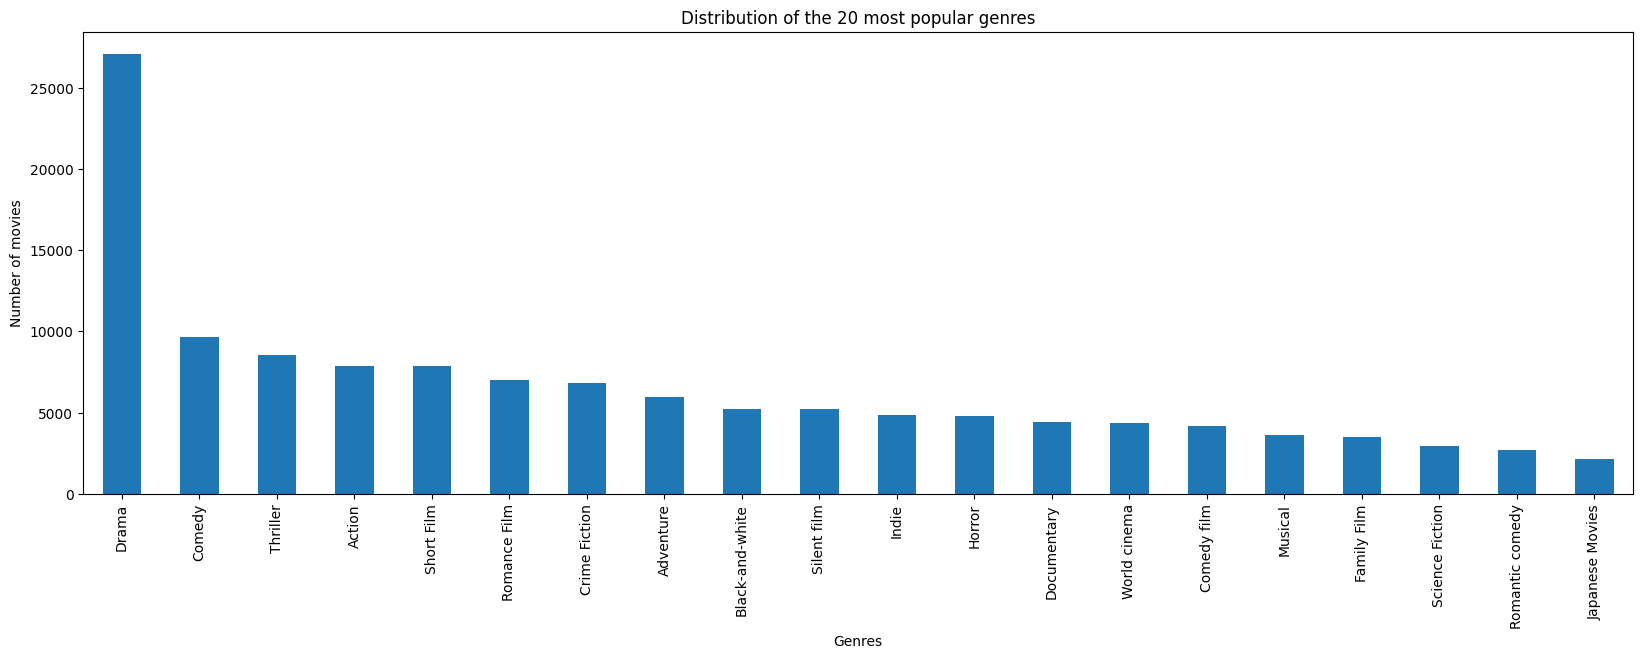

In [18]:
plt.figure(figsize=(20,6))
top20_genres.plot.bar()
plt.title("Distribution of the 20 most popular genres")
plt.xlabel('Genres')
plt.ylabel('Number of movies')

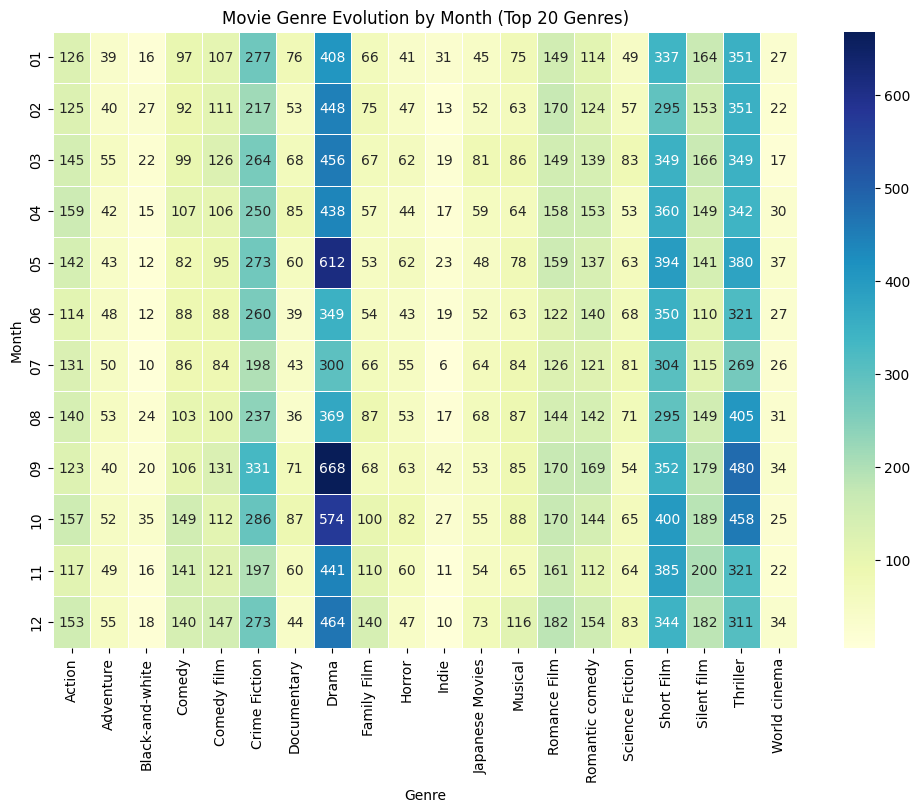

In [19]:
top_20_movies = movies[movies['Movie_genre_1'].isin(top20_genres.index)]

# Group the data by month and genre and calculate the count of movies in each category
genre_month_counts = top_20_movies.groupby(['Movie_release_month', 'Movie_genre_1']).size().unstack(fill_value=0)
genre_month_counts.head()

# Create a heatmap to visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(genre_month_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True, linewidths=0.5)
plt.title('Movie Genre Evolution by Month (Top 20 Genres)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

In [20]:
missing_data_points_movies = 100 * (movies.isna().sum() / (movies.shape[0]))

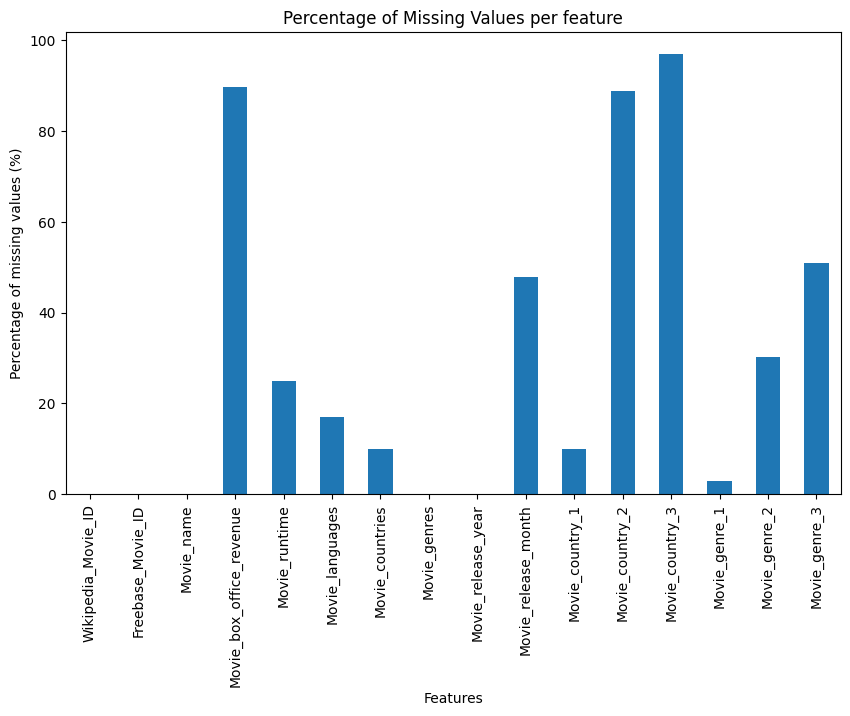

In [21]:
plt.figure(figsize=(10, 6))
missing_data_points_movies.plot(kind='bar')
plt.title('Percentage of Missing Values per feature')
plt.xlabel('Features')
plt.ylabel('Percentage of missing values (%)')
plt.xticks(rotation=90)
plt.show()

In [22]:
movies_copy = movies.dropna()

print(stats.pearsonr(movies_copy['Movie_runtime'], movies_copy['Movie_box_office_revenue']))

PearsonRResult(statistic=0.12304918283267, pvalue=0.007378712374618128)


#### 2) Characters

In [23]:
characters.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [24]:
characters[characters['Freebase_character_map']=='/m/02nwzzv'][:]

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
132619,54166,/m/0f4yh,Dr. Marcus Brody,1922-05-31,M,1.816,NaN,Denholm Elliott,59.0,/m/02nwzzv


In [25]:
missing_data_points_characters = 100 * (characters.isna().sum() / (characters.shape[0]))

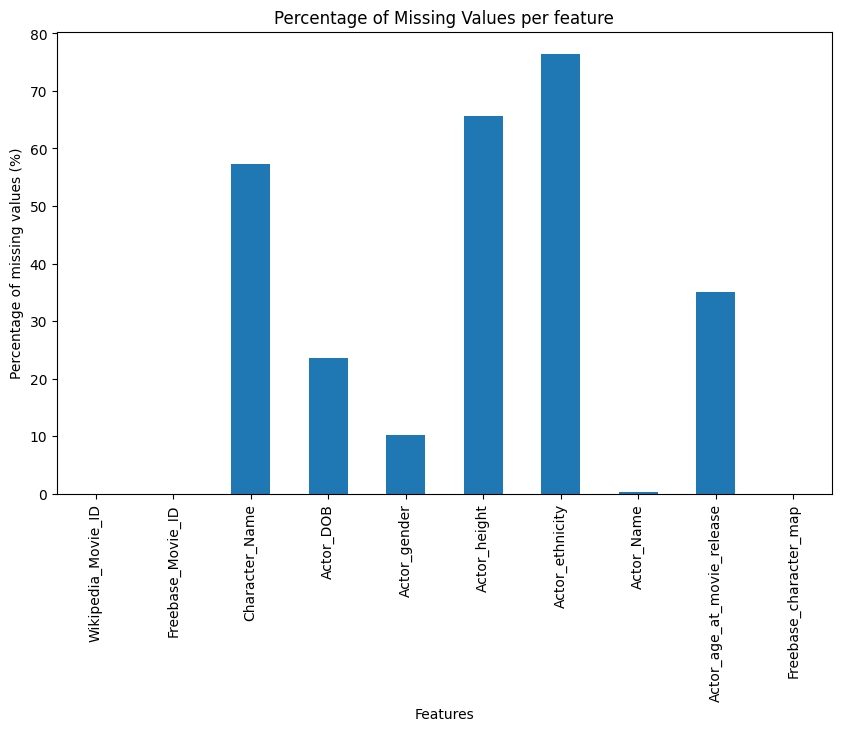

In [26]:
plt.figure(figsize=(10, 6))
missing_data_points_characters.plot(kind='bar')
plt.title('Percentage of Missing Values per feature')
plt.xlabel('Features')
plt.ylabel('Percentage of missing values (%)')
plt.xticks(rotation=90)
plt.show()

In [27]:
gender_counts = characters.groupby('Actor_gender').size()


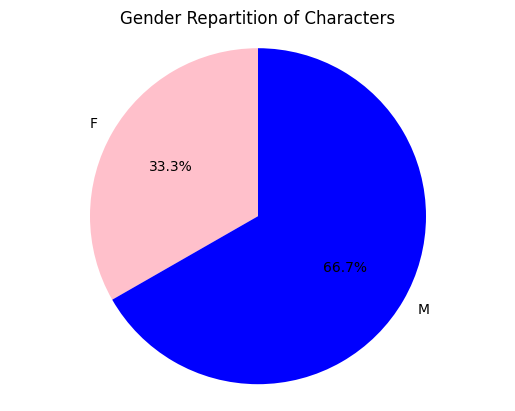

In [28]:
# Plotting a pie chart
fig, ax = plt.subplots()
ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'blue'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set the title
plt.title('Gender Repartition of Characters')

# Show the plot
plt.show()

In [30]:
# It seems like there are some actors with a negatif age. Let us remove them from our data set
characters[characters['Actor_age_at_movie_release'] < 0]

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
767,15007384,/m/03h4h5p,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3
2286,2553539,/m/07mlsy,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1
3892,5917218,/m/0fdf3y,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf
6666,73930,/m/0jsjm,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw
7188,21242801,/m/05bzjwj,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f
...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz
446581,25868401,/m/09v6ykm,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr
446583,8595532,/m/02799cv,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq
446816,1276915,/m/04pg6m,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j


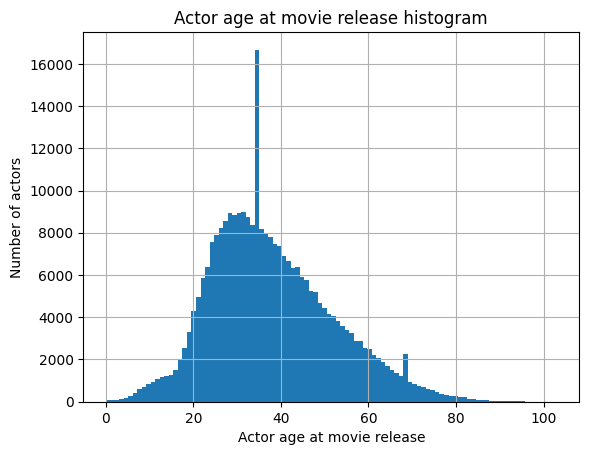

In [47]:
characters = characters[characters['Actor_age_at_movie_release'] >= 0]
characters['Actor_age_at_movie_release'].hist(bins = 100)
plt.xlabel('Actor age at movie release')
plt.ylabel('Number of actors')
plt.title('Actor age at movie release histogram');

In [37]:
# Again, it seems that there are some characaters with a height larger than 3 meters...
characters[characters['Actor_height'] > 3].shape

(13, 10)

In [70]:
characters = characters[characters['Actor_height'] < 3]

<Axes: >

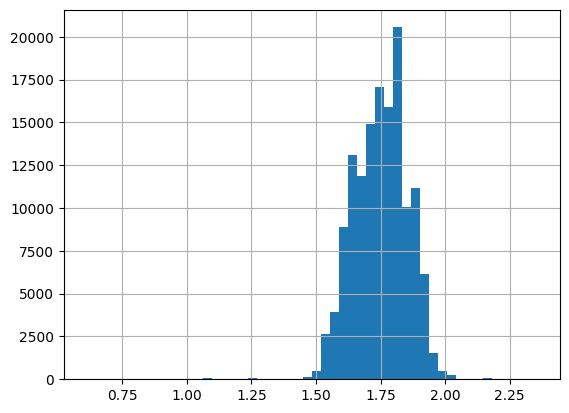

In [73]:
characters['Actor_height'].hist(bins = 50)

#### 3) Plot

In [92]:
columns_plot = ['Film ID', 'PLot summary']

plot = pd.read_table(DATA_FOLDER+'plot_summaries.txt', names=columns_plot)
plot.head()

,Film ID,PLot summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [22]:
movies_with_plot = movies['Wikipedia Movie ID'].isin(plot['Film ID']).sum()/len(movies)

print(f'Percentage of films with plots: {movies_with_plot:.2%}')

KeyError: 'Wikipedia Movie ID'

### Processing steps

In [ ]:
### Remove nan

### Process columns movie language, movie countries, movies genres

In [ ]:
print(movies['Movie languages'][0])
print(type(movies['Movie languages'][0]))

### Fetch data

In [ ]:
pip install IMDbPY

In [ ]:
import requests
from bs4 import BeautifulSoup